In [ ]:
import numpy as np
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers import SimpleRNN

tf.random.set_seed(1234)


### 演習に使用するデータについて



#### データのダウンロード

入手元：  
https://data.world/shad/covid-19-time-series-data

こちらに格納されている confirmed_pivot.csv をダウンロードする。

#### Google Colaboratory を使用する場合
ファイルを事前にダウンロードしておき、Google ドライブに保存しておく必要がある。  
次のコードを実行すると、Google Colab より Google ドライブへのアクセス権限を求められますので
許可を与えてください。

In [ ]:
from google.colab import drive

drive.mount("/content/drive")
# Googleドライブのマイドライブ直下にcsvファイルを保存している場合
df = pd.read_csv("/content/drive/MyDrive/confirmed_pivot.csv")
df


#### Google Colaboratory を使用しない場合

Jupyter Notebookと同じフォルダに confirmed_pivot.csv を格納しておく。

In [ ]:
# Google Colabを使わない場合
df = pd.read_csv("confirmed_pivot.csv")
df


### データの観察

#### 日本の感染者数を抽出
元のcsvデータは日毎の累積感染者数となっていることが確認できる。

In [ ]:
# 日本のデータを抽出
df_ja = df[df["country"] == "Japan"]
# 日付を2022/1/30までに制限
df_ja = df_ja[df_ja["date"] <= "2022-01-30"]
df_ja.sort_values(by="date")[["date", "total"]]


In [ ]:
plt.plot(list(df_ja.sort_values(by="date")["total"]))


#### 日別の新規感染者数に変換
第1～第6波の状況が見えるようになる。

In [ ]:
data = list(df_ja.sort_values(by="date")["total"])
new_data = []

for i in range(len(data)):
    if i == 0:
        new_data.append(data[i])
    else:
        new_data.append(data[i] - data[i - 1])


In [ ]:
plt.plot(new_data)
len(new_data)


### 学習データ、テストデータに分割
データが存在する期間のうち、前の60%を学習データ、後の40%をテストデータとする。

In [ ]:
split_ratio = 0.6

train_data = new_data[: int(len(new_data) * split_ratio)]
test_data = new_data[int(len(new_data) * split_ratio) :]

len(train_data), len(test_data)


### データの正規化

機械学習による予測モデルへの入力に使いやすいように、入力値の正規化を行う。  

学習データの最大値を基準として、0〜1の値になるように線形変換する。  
（テストデータには学習データの最大値を超える値があるため、テストデータにおいて1を超える値が存在する。）

In [ ]:
max_value = np.max(train_data)  # 学習データの最大値

test_data = np.array(test_data) / max_value
train_data = np.array(train_data) / max_value


In [ ]:
plt.plot(list(range(len(train_data))), train_data)
plt.plot(list(range(len(train_data), len(new_data))), test_data)
plt.legend(["train", "test"])


### RNNによる予測モデルの構築
1週間分の新規感染者を入力とし、1週間後の新規感染者数を出力とするRNNを構築する

In [ ]:
# 入力の時系列長
seq_len = 7

x_train = []
y_train = []

for i in range(len(train_data) - seq_len - 7):
    x_train.append(train_data[i : i + seq_len])
    y_train.append(train_data[i + seq_len - 1 + 7])

x_train = np.array(x_train).reshape(-1, seq_len, 1)
y_train = np.array(y_train).reshape(-1, 1)


In [ ]:
x_test = []
y_test = []

for i in range(len(test_data) - seq_len - 7):
    x_test.append(test_data[i : i + seq_len])
    y_test.append(test_data[i + seq_len - 1 + 7])

x_test = np.array(x_test).reshape(-1, seq_len, 1)
y_test = np.array(y_test).reshape(-1, 1)


In [ ]:
np.shape(x_train), np.shape(y_train)


### KerasでRNNを学習

RNN の学習については numpy だけで実装すると複雑になるので、Tensorflow-Keras を使う。
（Keras での学習によって得られた重み行列とバイアスの圧縮を試みる。）

まずは RNN の隠れベクトルの次元数を32として学習する。

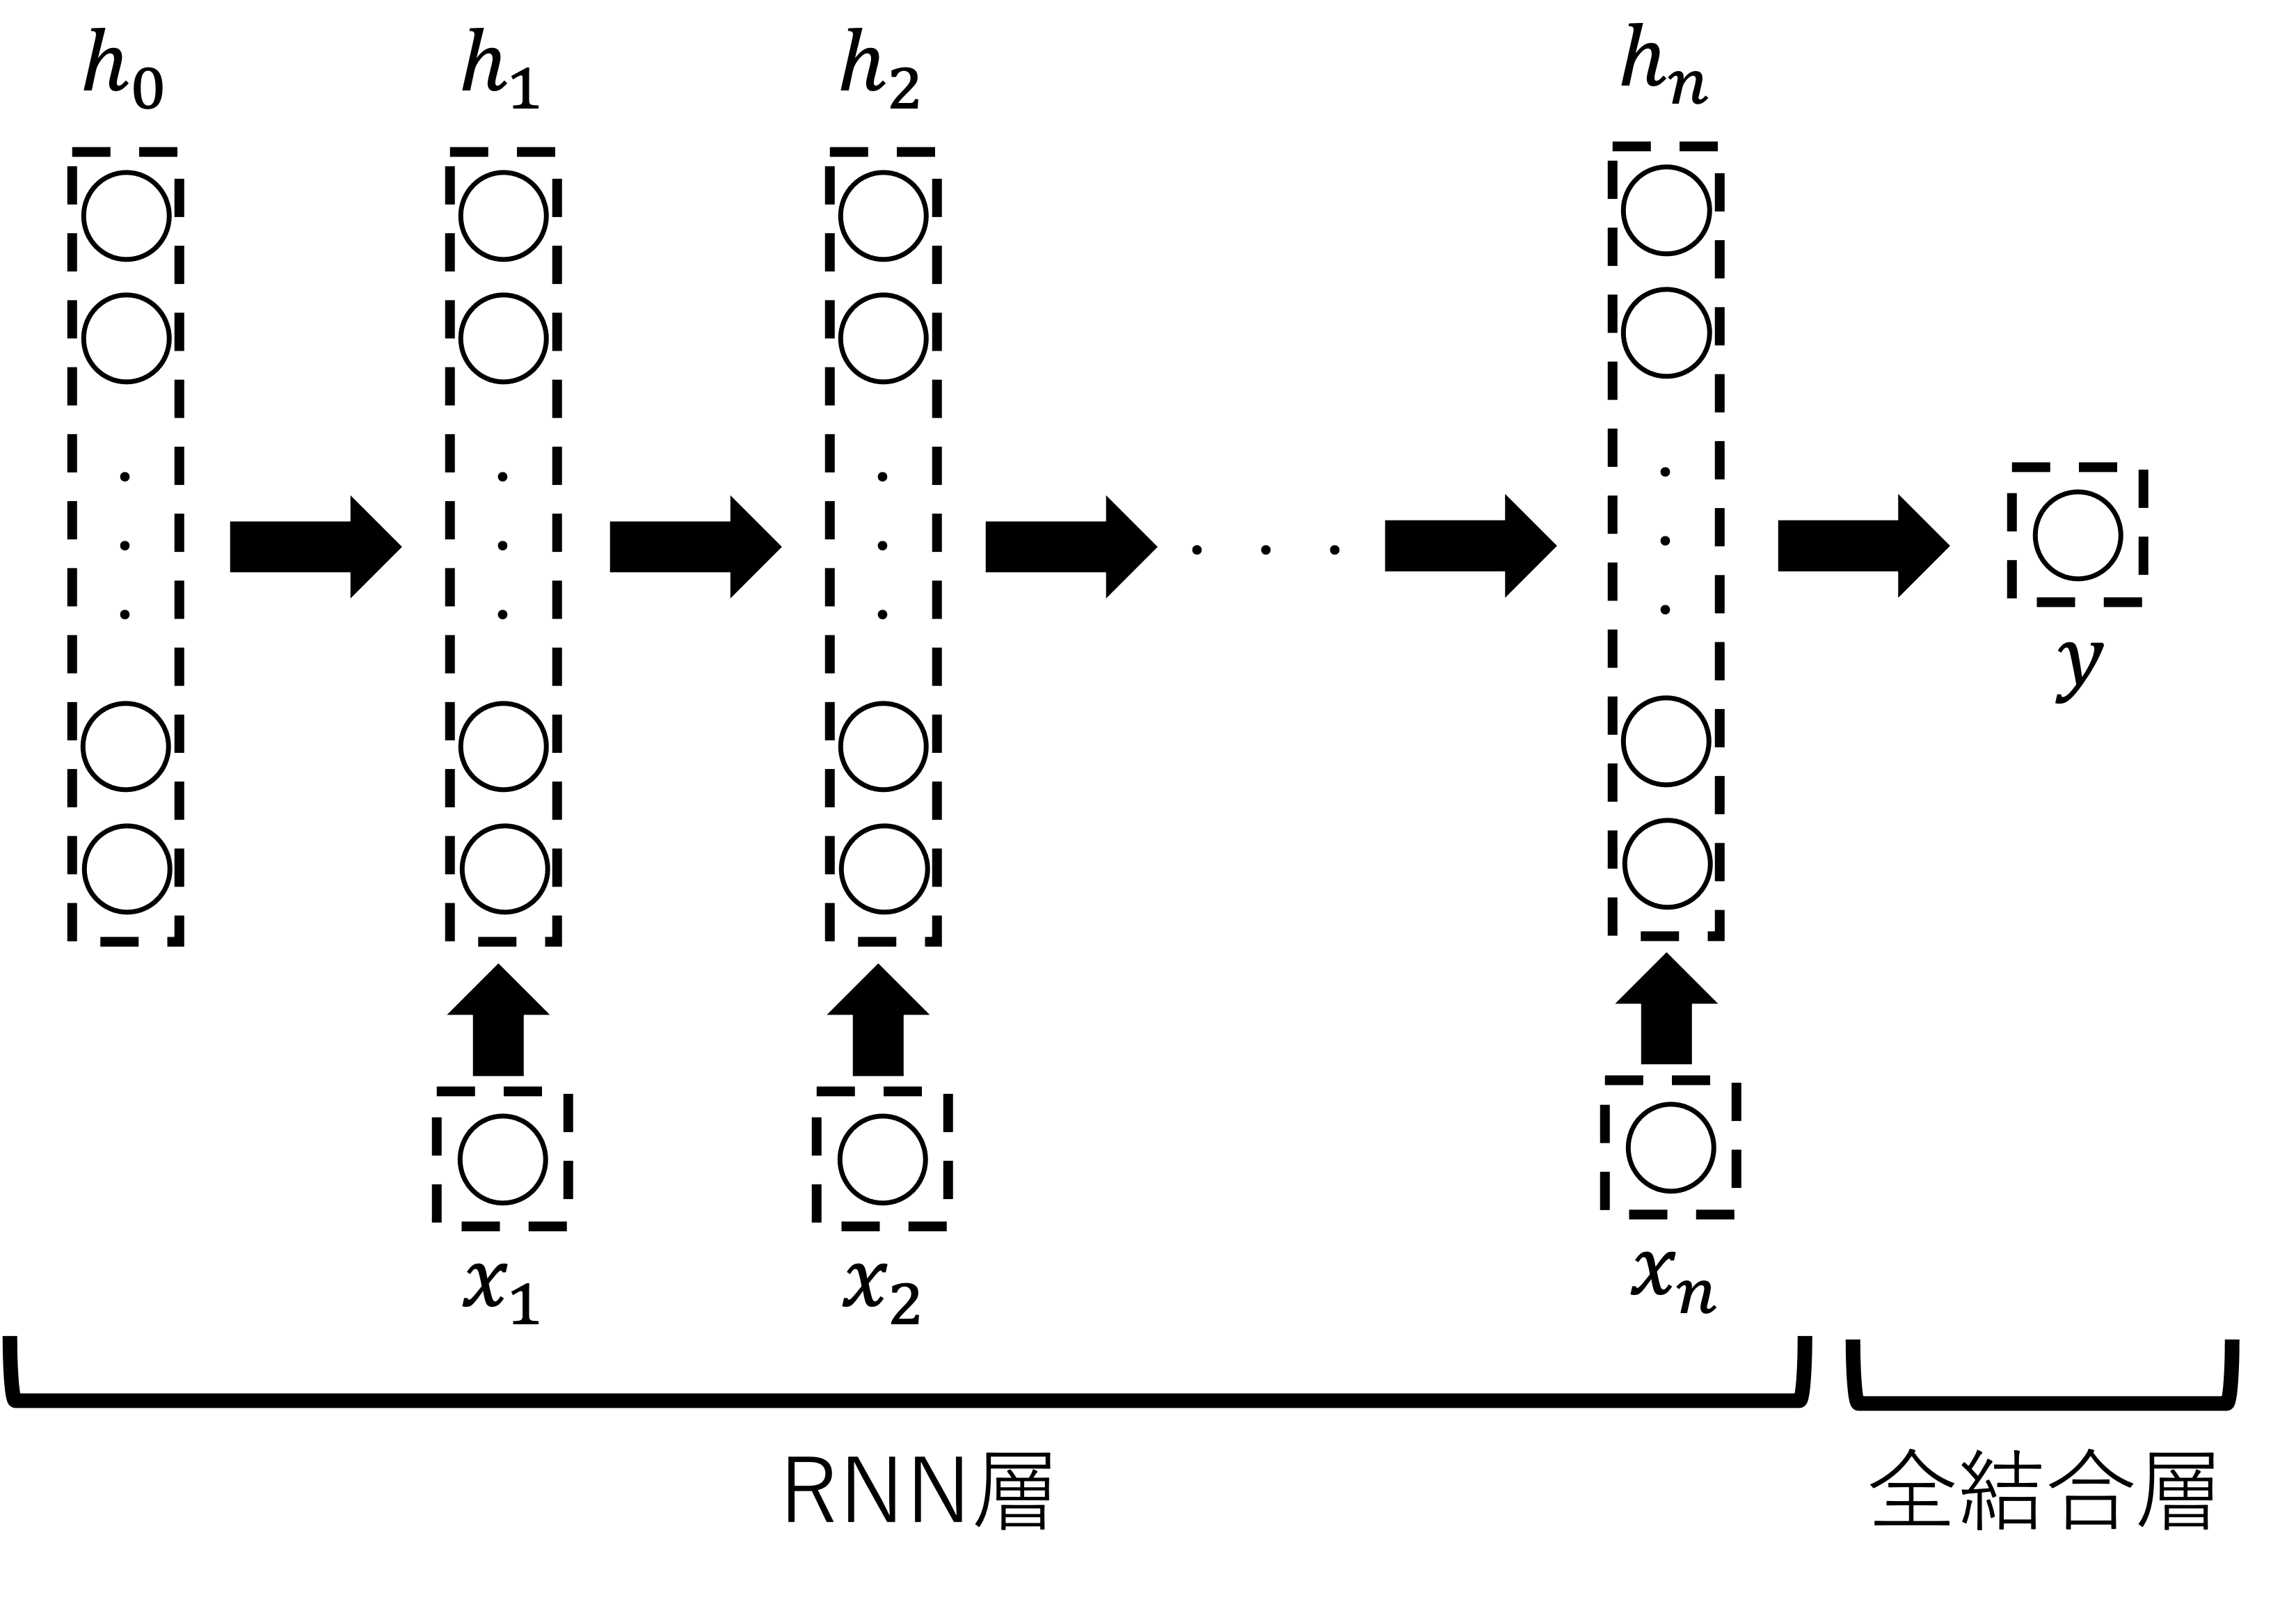

入力データ：$x = \{x_1,x_2,\ldots, x_n \}$　　※ 今回の場合n=7  
RNN層： $ h_t = W_h h_{t-1} + W_x x_t + b_r $  
全結合層： $ y = W_d h_n + b_d $  
$t = 1$のときには $h_0 = 0$ として計算する。

$h_t$ の次元数を 32 とする場合、  
- $W_h$ は $32 \times 32$ 行列
- $W_x, b_r, W_d$ は 32次元
- $b_d$ は 1次元

で、パラメータ総数は 32 * 32 + 32 * 3 +1 = 1121 となる。

In [ ]:
# RNN隠れベクトルの次元数
hidden_dim = 32


In [ ]:
def covid19_rnn_model(x, y, hidden_dim):
    model = Sequential()
    model.add(
        SimpleRNN(
            hidden_dim,
            input_shape=(np.shape(x)[1], np.shape(x)[2]),
            activation="tanh",
            return_sequences=False,
            name="rnn",
        )
    )
    model.add(Dense(np.shape(y)[1], name="dense"))
    model.compile(loss="mean_squared_error", optimizer="SGD")
    return model


In [ ]:
model = covid19_rnn_model(x_train, y_train, hidden_dim)
model.summary()
history = model.fit(x_train, y_train, epochs=200, verbose=1)


In [ ]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epochs")


### 予測

学習した重みを使って、kerasを使わずに numpy で予測を行う。

In [ ]:
def covid19_rnn_predict(model, x, h_dim):
    rnn = model.get_layer(name="rnn")
    dense = model.get_layer(name="dense")

    # 初期値設定 (h_0 はゼロベクトルで初期化する)
    h_0 = np.zeros(h_dim)
    W_h = rnn.get_weights()[1]
    W_x = rnn.get_weights()[0]
    b_r = rnn.get_weights()[2]

    W_d = dense.get_weights()[0]
    b_d = dense.get_weights()[1]

    y_pred = []

    for x_sample in x:
        # RNN
        h_t_1 = h_0
        for t in range(np.shape(x_sample)[0]):
            x_t = x_sample[t]
            h_t = np.tanh(np.matmul(W_h, h_t_1) + np.matmul(W_x.T, x_t) + b_r)
            h_t_1 = h_t
        # Dense
        y = np.dot(W_d.T, h_t_1) + b_d
        y_pred.append(y)

    return y_pred


In [ ]:
# y_pred = model.predict(x_test)
y_pred = covid19_rnn_predict(model, x_test, hidden_dim)
plt.plot(y_pred)
plt.plot(y_test)
plt.legend(["prediction", "real"])


### RNNの次元圧縮と予測モデルの関係

RNNの隠れベクトルの次元数を変えると、予測結果がどのように変化するのかを確認してみる。
次元が大きくなるにつれて、以下の様子が確認できる。

- MSEが減少する ＝ 予測する感染の波が高くなる
- 感染者数が曜日に依存することを学習できる ＝ グラフが滑らかな曲線から折れ線状になる
- 感染者数が増加から減少に転ずるタイミングを予測できる（増加し始めるタイミングはあまり予測できていない）


In [ ]:
hidden_nums = [4, 8, 16, 32, 64, 128, 256, 512]

y_preds = []
for h_dim in hidden_nums:
    model = covid19_rnn_model(x_train, y_train, h_dim)
    model.fit(x_train, y_train, epochs=200, verbose=0)
    y_pred = covid19_rnn_predict(model, x_test, h_dim)
    # y_pred = model.predict(x_test)
    y_preds.append(y_pred)


In [ ]:
plt.figure(figsize=(15, 15))

for i, y_pred in enumerate(y_preds):
    mse = np.sum(np.square(y_test - y_pred)) / np.shape(y_test)[0]
    plt.subplot(331 + i)
    plt.plot(y_pred)
    plt.plot(y_test)
    plt.title("hidden= %d, mse= %f" % (hidden_nums[i], mse))


## 特異値分解

データ圧縮の実装例として、
h_dim=256 のときの $W_h$ を特異値分解によって圧縮する例を示す。

再び RNN の学習を行う。

In [ ]:
h_dim = 256

model = covid19_rnn_model(x_train, y_train, h_dim)
model.fit(x_train, y_train, epochs=200, verbose=0)
y_pred = covid19_rnn_predict(model, x_test, h_dim)

mse = np.sum(np.square(y_test - y_pred)) / np.shape(y_test)[0]
plt.plot(y_pred)
plt.plot(y_test)
plt.title("hidden= %d, mse= %f" % (256, mse))


学習した重みを取得する。

In [ ]:
rnn = model.get_layer(name="rnn")
W_h = rnn.get_weights()[1]
W_x = rnn.get_weights()[0]
b_r = rnn.get_weights()[2]


$W_h$ を特異値分解して、結果を表示する。  
<font color="red">演習ではこの部分のコードをテンソルネットワークを使った計算に変更します。</font>

In [ ]:
from numpy.linalg import svd, matrix_rank

print("matrix W_h\n", W_h)
print("rank: ", matrix_rank(W_h))

# singular value decomposition
u, s, vh = svd(W_h)
print("\nSVD result")
print("shape of u, s, vh:", u.shape, s.shape, vh.shape)
print("singular values:", s.round(2))

# 復元
W_re = u @ np.diag(s) @ vh
print("\nreconstructed W_h:\n", W_re)


covid19_rnn_predict を改変して、特異値分解した $W_h$ から予測できるようにする。  
<font color="red">演習ではデータ圧縮方法に合わせた、covid19_rnn_predict 関数を作成します。</font>

In [ ]:
def covid19_rnn_predict_SVD(model, x, h_dim, u, s, vh):
    rnn = model.get_layer(name="rnn")
    dense = model.get_layer(name="dense")

    # 初期値設定 h_0 はゼロベクトルで初期化する
    h_0 = np.zeros(h_dim)
    # W_hだけ特異値分解の結果から作る
    # W_h = rnn.get_weights()[1]
    W_h = u @ np.diag(s) @ vh

    W_x = rnn.get_weights()[0]
    b_r = rnn.get_weights()[2]

    W_d = dense.get_weights()[0]
    b_d = dense.get_weights()[1]

    y_pred = []

    for x_sample in x:
        # RNN
        h_t_1 = h_0
        for t in range(np.shape(x_sample)[0]):
            x_t = x_sample[t]
            h_t = np.tanh(np.matmul(W_h, h_t_1) + np.matmul(W_x.T, x_t) + b_r)
            h_t_1 = h_t
        # Dense
        y = np.dot(W_d.T, h_t_1) + b_d
        y_pred.append(y)

    return y_pred


圧縮率を変化させて、予測結果に与える影響を比較する。  
<font color="red">演習では、作成した covid19_rnn_predict 関数に合わせてこの部分も変更します。</font>

In [ ]:
s_dims = [8, 16, 32, 64, 128, 256]  # 256は分解無と同等
y_preds = []

# 特異値分解
rnn = model.get_layer(name="rnn")
W_h = rnn.get_weights()[1]
u, s, vh = svd(W_h)

for s_dim in s_dims:
    # s_dim分だけ部分行列を取り出す
    u_small = u[:, :s_dim]
    s_small = s[:s_dim]
    vh_small = vh[:s_dim, :]

    y_pred = covid19_rnn_predict_SVD(model, x_test, h_dim, u_small, s_small, vh_small)
    y_preds.append(y_pred)


予測結果を表示する。
<font color="red">この部分は変更不要となる想定です。</font>

In [ ]:
plt.figure(figsize=(15, 15))

for i, y_pred in enumerate(y_preds):
    mse = np.sum(np.square(y_test - y_pred)) / np.shape(y_test)[0]
    plt.subplot(331 + i)
    plt.plot(y_pred)
    plt.plot(y_test)
    plt.title("SVD dim= %d, mse= %f" % (s_dims[i], mse))


### 2サイトの行列積分解
$ W_h $ を横方向に特異値分解してみる。
h_dim = 256

$256 \otimes 256$ の行列を $16 \otimes 16 \otimes 16 \otimes 16$ の4本足テンソルにreshape

In [ ]:
rnn = model.get_layer(name="rnn")
W_h = rnn.get_weights()[1]

W_h_tensor = W_h.reshape(16, 16, 16, 16)


さらに足を並び替え（transpose）したあと、別の形の$256 \otimes 256$ の行列に変形（reshape）する。

In [ ]:
W_h_tensor = W_h_tensor.transpose(0, 2, 1, 3).reshape(256, 256)


この新しい行列に対して、特異値分解による低ランク近似を行う。
これは、2サイトの行列演算子にテンソルネットワーク分解することと等価

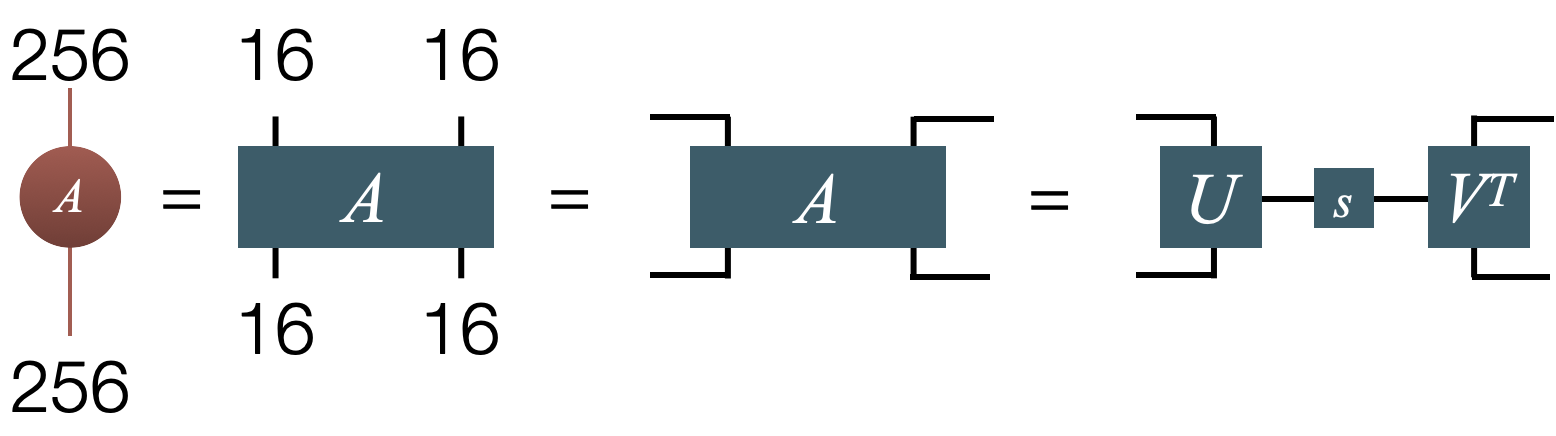

In [ ]:
print("matrix W_h\n", W_h_tensor)
print("rank: ", matrix_rank(W_h_tensor))

# singular value decomposition
u, s, vh = svd(W_h_tensor)
print("\nSVD result")
print("shape of u, s, vh:", u.shape, s.shape, vh.shape)
print("singular values:", s.round(2))

# 復元
W_re_tensor = u @ np.diag(s) @ vh
print("\nreconstructed W_h:\n", W_re_tensor)


In [ ]:
def covid19_rnn_predict_tensor_SVD(model, x, h_dim, u, s, vh, tensor_legs):
    rnn = model.get_layer(name="rnn")
    dense = model.get_layer(name="dense")

    # 初期値設定 h_0 はゼロベクトルで初期化する
    h_0 = np.zeros(h_dim)

    # W_hだけ横方向の特異値分解の結果から作る
    # W_h = rnn.get_weights()[1]
    W_h = (
        (u @ np.diag(s) @ vh)
        .reshape(tensor_legs)
        .transpose(0, 2, 1, 3)
        .reshape(h_dim, h_dim)
    )

    W_x = rnn.get_weights()[0]
    b_r = rnn.get_weights()[2]

    W_d = dense.get_weights()[0]
    b_d = dense.get_weights()[1]

    y_pred = []

    for x_sample in x:
        # RNN
        h_t_1 = h_0
        for t in range(np.shape(x_sample)[0]):
            x_t = x_sample[t]
            h_t = np.tanh(np.matmul(W_h, h_t_1) + np.matmul(W_x.T, x_t) + b_r)
            h_t_1 = h_t
        # Dense
        y = np.dot(W_d.T, h_t_1) + b_d
        y_pred.append(y)

    return y_pred


2サイトの行列積分解後、次元圧縮を行い、性能の変化を確認する。  
パラメータ数は $256 \times 256 \rightarrow 256 \times k + k + k \times 256 = 513 \times k$
で、普通の特異値分解と同様

In [ ]:
s_dims = [1, 2, 4, 8, 16, 32, 64, 128, 256]  # 256は分解無と同等
y_preds_tensor = []
tensor_legs = [16, 16, 16, 16]

# 特異値分解
rnn = model.get_layer(name="rnn")
W_h = (
    rnn.get_weights()[1].reshape(16, 16, 16, 16).transpose(0, 2, 1, 3).reshape(256, 256)
)

u, s, vh = svd(W_h)

for s_dim in s_dims:
    # s_dim分だけ部分行列を取り出す
    u_small = u[:, :s_dim]
    s_small = s[:s_dim]
    vh_small = vh[:s_dim, :]

    y_pred = covid19_rnn_predict_tensor_SVD(
        model, x_test, h_dim, u_small, s_small, vh_small, tensor_legs
    )
    y_preds_tensor.append(y_pred)


In [ ]:
plt.figure(figsize=(15, 15))

for i, y_pred in enumerate(y_preds_tensor):
    mse = np.sum(np.square(y_test - y_pred)) / np.shape(y_test)[0]
    plt.subplot(331 + i)
    plt.plot(y_pred)
    plt.plot(y_test)
    plt.title("SVD dim= %d, mse= %f" % (s_dims[i], mse))


### 4サイトの行列積分解
次に、$ W_h $ を4サイトの行列積演算子に分解してみる
h_dim = 256

$256 \otimes 256$ の行列を $4 \otimes 4 \otimes 4 \otimes 4 \otimes 4 \otimes 4 \otimes 4 \otimes 4$ の8本足テンソルにreshapeする。足が増えたので分かりにくいが、前半の4本の足が元の行列の「行」後半の4本の足が、元の行列の「列」になっている。


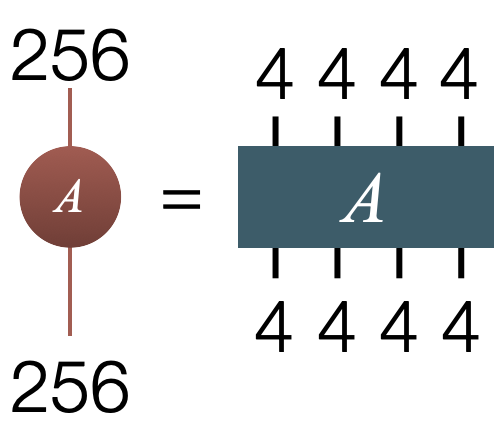

In [ ]:
rnn = model.get_layer(name="rnn")
W_h = rnn.get_weights()[1]
W_h_tensor = W_h.reshape(4, 4, 4, 4, 4, 4, 4, 4)


このテンソルを、「行」と「列」の足が隣り合わせで組になるように、transposeし、その後、$16 \otimes 16 \otimes 16 \otimes 16$の4本足のテンソルにreshapeする。これは、上の図で"対応する"上下の足をセットにして一つの一つのindexにしたことに相当している。

In [ ]:
W_h_tensor = W_h_tensor.transpose(0, 4, 1, 5, 2, 6, 3, 7).reshape(16, 16, 16, 16)


左の足から順番に特異値分解を繰り返して、近似のない行列積状態を作成する。

In [ ]:
u1, s1, vh1 = svd(W_h_tensor.reshape(16, 16**3), full_matrices=False)


M1 = u1
u2, s2, vh2 = svd((np.diag(s1) @ vh1).reshape(16**2, 16**2), full_matrices=False)
M2 = u2.reshape(16, 16, 16**2)

u3, s3, vh3 = svd((np.diag(s2) @ vh2).reshape(16**3, 16), full_matrices=False)

M3 = u3.reshape(16**2, 16, 16)

M4 = np.diag(s3) @ vh3


ここでできた4つのテンソル、M1, M2, M3, M4は、M1とM4が2本足、M2とM3が3本足のテンソルになっている。
（今は、図の上の足と下の足が一つのindexにまとまっていることに注意）

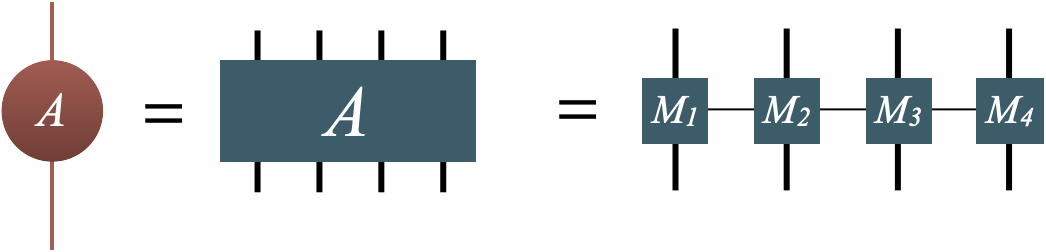

4つのテンソルから元のAを再構成する関数を作成しておく

In [ ]:
def reconstruct_matrix(M1, M2, M3, M4):
    ## tensordotを使う場合
    ## matrix = np.tensordot(np.tensordot(np.tensordot(M1,M2,(1,0)),M3,(2,0)), M4,(3,0)).reshape(4,4,4,4,4,4,4,4).transpose(0,2,4,6,1,3,5,7).reshape(256,256)

    ## einsumを使う場合
    matrix = (
        np.einsum("ij,jlm,mno,op -> ilnp", M1, M2, M3, M4, optimize=True)
        .reshape(4, 4, 4, 4, 4, 4, 4, 4)
        .transpose(0, 2, 4, 6, 1, 3, 5, 7)
        .reshape(256, 256)
    )

    return matrix


In [ ]:
W_h_reconstructed = reconstruct_matrix(M1, M2, M3, M4)

## 誤差の確認
np.linalg.norm(W_h - W_h_reconstructed) / np.linalg.norm(W_h)


この行列積分解をボンド次元を小さくすることで近似する。行列積分解を特異値分解で作ったため、対応するボンドで小さい特異値を無視するためには、indexの最大値を制限すれば良い。

In [ ]:
chi_max = 32

## M1 と M2をつなぐボンド
chi_12 = min(chi_max, M1.shape[1])
## M2 と M3をつなぐボンド
chi_23 = min(chi_max, M2.shape[2])
## M3 と M4をつなぐボンド
chi_34 = min(chi_max, M3.shape[2])

M1_ap = M1[:, :chi_12]
M2_ap = M2[:chi_12, :, :chi_23]
M3_ap = M3[:chi_23, :, :chi_34]
M4_ap = M4[:chi_34, :]

W_h_ap = reconstruct_matrix(M1_ap, M2_ap, M3_ap, M4_ap)
## 誤差の確認
np.linalg.norm(W_h - W_h_ap) / np.linalg.norm(W_h)


ボンド次元（chi_max）を変えることで、近似（データ圧縮）の度合いをコントロールできる。

また、同様にして$256 = 2^8$に分解することで、8サイトでの行列積分解に拡張することもできる。
（行列積への分解では必ずしも、全ての足で大きさが揃っていなくても良いので、例えば（2,2,2,2,4,4),として6サイトに分解しても良い）

chi_maxや、分解の仕方で時系列予測の精度がどう変わるだろうか？

## 演習（ここから）

上記、Pythonの実装コードを参考に $W_h$ の圧縮を行い、RNN予測モデルに与える影響を観察します。

- \[step1\] 4サイトの行列積分解を行った場合
- \[step2\] 他の行列積分解で同様の実験を行った場合

In [ ]:
s_dims = [8, 16, 32, 64, 128, 256]  # 256は分解無と同等
y_preds = []

rnn = model.get_layer(name="rnn")
W_h = rnn.get_weights()[1]

"""
u, s, vh = svd(W_h)

for s_dim in s_dims:
    # s_dim分だけ部分行列を取り出す
    u_small = u[:, :s_dim]
    s_small = s[:s_dim]
    vh_small = vh[:s_dim, :]
    
    y_pred = covid19_rnn_predict_SVD(model, x_test, h_dim, u_small, s_small, vh_small)
    y_preds.append(y_pred)
"""


In [ ]:
def covid19_rnn_predict_original(model, x, h_dim, W_h):
    rnn = model.get_layer(name="rnn")
    dense = model.get_layer(name="dense")

    # 初期値設定 h_0 はゼロベクトルで初期化する
    h_0 = np.zeros(h_dim)

    """
    # W_hだけ特異値分解の結果から作る
    # W_h = rnn.get_weights()[1]
    W_h = (u @ np.diag(s) @ vh)
    """

    W_x = rnn.get_weights()[0]
    b_r = rnn.get_weights()[2]

    W_d = dense.get_weights()[0]
    b_d = dense.get_weights()[1]

    y_pred = []

    for x_sample in x:
        # RNN
        h_t_1 = h_0
        for t in range(np.shape(x_sample)[0]):
            x_t = x_sample[t]
            h_t = np.tanh(np.matmul(W_h, h_t_1) + np.matmul(W_x.T, x_t) + b_r)
            h_t_1 = h_t
        # Dense
        y = np.dot(W_d.T, h_t_1) + b_d
        y_pred.append(y)

    return y_pred


In [ ]:
from numpy.linalg import svd, matrix_rank

"""
# singular value decomposition
u, s, vh = svd(W_h)
print('\nSVD result')
print('shape of u, s, vh:', u.shape, s.shape, vh.shape)
print('singular values:', s.round(2))

# 復元
W_re = (u @ np.diag(s) @ vh)
print('\nreconstructed W_h:\n', W_re)
"""


In [ ]:
plt.figure(figsize=(15, 15))

for i, y_pred in enumerate(y_preds):
    mse = np.sum(np.square(y_test - y_pred)) / np.shape(y_test)[0]
    plt.subplot(331 + i)
    plt.plot(y_pred)
    plt.plot(y_test)
    plt.title("SVD dim= %d, mse= %f" % (s_dims[i], mse))


## 演習（ここまで）

## 発展課題
モデルを改良する、データを変える、モデルの重みパラメータを変える等を行うことによって
同様の実験を行ってみる。

（例）
- x_train に移動平均等の特徴量を追加して入力の次元を増やす。  
第 $n$ 日の感染者数を $x_n$ で表すと、期間 $d$ の単純移動平均は
$ (x_n + x_{n-1} + \cdots + x_{n-d+1}) / d $
で求められる。

- RNNの時系列長を7日より長くする、あるいは短くする。

- 日本以外の国の感染者数データを使って、同様の実験を行ってみる。

In [ ]:
# 1次元のリストとなった時系列データを単純移動平均に変換する
def simple_moving_average(x, days=7):
    y = [x[0]] * (days - 1) + x
    ret = [sum(y[i : i + days]) / days for i in range(len(x))]
    return ret


# train_data を単純移動平均に変換
train_sma = simple_moving_average(train_data.tolist())


## 回答例
- \[step1\] 4サイトの行列積分解を行った場合

In [ ]:
# 圧縮後に復元した W_h を使う
y_pred = covid19_rnn_predict_original(model, x_test, h_dim, W_h_ap)

plt.plot(y_pred)
plt.plot(y_test)


- \[step2\] 他の行列積分解で同様の実験を行った場合

In [ ]:
# 例として、(2,2,2,2,4,4) の6サイトに分解してみる
rnn = model.get_layer(name="rnn")
W_h = rnn.get_weights()[1]
W_h_tensor = W_h.reshape(2, 2, 2, 2, 4, 4, 2, 2, 2, 2, 4, 4)

W_h_tensor = W_h_tensor.transpose(0, 6, 1, 7, 2, 8, 3, 9, 4, 10, 5, 11).reshape(
    4, 4, 4, 4, 16, 16
)

u1, s1, vh1 = svd(W_h_tensor.reshape(4, 4**3 * 16**2), full_matrices=False)
M1 = u1

u2, s2, vh2 = svd(
    (np.diag(s1) @ vh1).reshape(4**2, 4**2 * 16**2), full_matrices=False
)
M2 = u2.reshape(4, 4, 4**2)

u3, s3, vh3 = svd((np.diag(s2) @ vh2).reshape(4**3, 4 * 16**2), full_matrices=False)
M3 = u3.reshape(4**2, 4, 4 * 16)

u4, s4, vh4 = svd((np.diag(s3) @ vh3).reshape(4**4, 16**2), full_matrices=False)
M4 = u4.reshape(4 * 16, 4, 16**2)

u5, s5, vh5 = svd((np.diag(s4) @ vh4).reshape(4**4 * 16, 16), full_matrices=False)
M5 = u5.reshape(16**2, 16, 16)

M6 = np.diag(s5) @ vh5
W_h_reconstructed = (
    np.einsum("ij,jlm,mno,opq,qrs,st -> ilnprt", M1, M2, M3, M4, M5, M6, optimize=True)
    .reshape(2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4)
    .transpose(0, 2, 4, 6, 8, 10, 1, 3, 5, 7, 9, 11)
    .reshape(256, 256)
)

## 誤差の確認
np.linalg.norm(W_h - W_h_reconstructed) / np.linalg.norm(W_h)


In [ ]:
# 例として、(2,2,4,4,4) の5サイトに分解してみる
rnn = model.get_layer(name="rnn")
W_h = rnn.get_weights()[1]
W_h_tensor = W_h.reshape(2, 2, 4, 4, 4, 2, 2, 4, 4, 4)

W_h_tensor = W_h_tensor.transpose(0, 5, 1, 6, 2, 7, 3, 8, 4, 9).reshape(
    4, 4, 16, 16, 16
)

u1, s1, vh1 = svd(W_h_tensor.reshape(4, 4 * 16**3), full_matrices=False)
M1 = u1

u2, s2, vh2 = svd((np.diag(s1) @ vh1).reshape(4**2, 16**3), full_matrices=False)
M2 = u2.reshape(4, 4, 16)

u3, s3, vh3 = svd(
    (np.diag(s2) @ vh2).reshape(4**2 * 16, 16**2), full_matrices=False
)
M3 = u3.reshape(16, 16, 16**2)

u4, s4, vh4 = svd(
    (np.diag(s3) @ vh3).reshape(4**2 * 16**2, 16), full_matrices=False
)
M4 = u4.reshape(16**2, 16, 16)

M5 = np.diag(s4) @ vh4
W_h_reconstructed = (
    np.einsum("ij,jlm,mno,opq,qr -> ilnpr", M1, M2, M3, M4, M5, optimize=True)
    .reshape(2, 2, 2, 2, 4, 4, 4, 4, 4, 4)
    .transpose(0, 2, 4, 6, 8, 1, 3, 5, 7, 9)
    .reshape(256, 256)
)

## 誤差の確認
np.linalg.norm(W_h - W_h_reconstructed) / np.linalg.norm(W_h)


In [ ]:
chi_max = 8

## M1 と M2をつなぐボンド
chi_12 = min(chi_max, M1.shape[1])
## M2 と M3をつなぐボンド
chi_23 = min(chi_max, M2.shape[2])
## M3 と M4をつなぐボンド
chi_34 = min(chi_max, M3.shape[2])
## M4 と M5をつなぐボンド
chi_45 = min(chi_max, M4.shape[2])

M1_ap = M1[:, :chi_12]
M2_ap = M2[:chi_12, :, :chi_23]
M3_ap = M3[:chi_23, :, :chi_34]
M4_ap = M4[:chi_34, :, :chi_45]
M5_ap = M5[:chi_45, :]

W_h_ap = (
    np.einsum(
        "ij,jlm,mno,opq,qr -> ilnpr", M1_ap, M2_ap, M3_ap, M4_ap, M5_ap, optimize=True
    )
    .reshape(2, 2, 2, 2, 4, 4, 4, 4, 4, 4)
    .transpose(0, 2, 4, 6, 8, 1, 3, 5, 7, 9)
    .reshape(256, 256)
)
## 誤差の確認
np.linalg.norm(W_h - W_h_ap) / np.linalg.norm(W_h)


In [ ]:
# 圧縮後に復元した W_h を使う
y_pred = covid19_rnn_predict_original(model, x_test, h_dim, W_h_ap)

plt.plot(y_pred)
plt.plot(y_test)


## 発展課題の回答例

RNNの時系列長を7日より長くする、あるいは短くする。

In [ ]:
# 入力の時系列長
seq_len = 14

x_train = []
y_train = []

for i in range(len(train_data) - seq_len - 7):
    x_train.append(train_data[i : i + seq_len])
    y_train.append(train_data[i + seq_len - 1 + 7])

x_train = np.array(x_train).reshape(-1, seq_len, 1)
y_train = np.array(y_train).reshape(-1, 1)


In [ ]:
x_test = []
y_test = []

for i in range(len(test_data) - seq_len - 7):
    x_test.append(test_data[i : i + seq_len])
    y_test.append(test_data[i + seq_len - 1 + 7])

x_test = np.array(x_test).reshape(-1, seq_len, 1)
y_test = np.array(y_test).reshape(-1, 1)


In [ ]:
model = covid19_rnn_model(x_train, y_train, hidden_dim)
model.summary()
history = model.fit(x_train, y_train, epochs=200, verbose=1)


In [ ]:
y_pres = covid19_rnn_predict(model, x_test, hidden_dim)
plt.plot(y_pred)
plt.plot(y_test)
plt.title("hidden= %d, mse= %f" % (256, mse))


移動平均を特徴量に追加して、入力を2次元にする。

In [ ]:
x_train = []
x_train_sma = []
y_train = []

train_sma = simple_moving_average(train_data.tolist())

for i in range(len(train_data) - seq_len - 7):
    x_train.append(train_data[i : i + seq_len])
    y_train.append(train_data[i + seq_len - 1 + 7])
    x_train_sma.append(train_sma[i : i + seq_len])

x_train = np.array(x_train).reshape(-1, seq_len, 1)
x_train_sma = np.array(x_train_sma).reshape(-1, seq_len, 1)
x_train = np.concatenate([x_train, x_train_sma], axis=2)
y_train = np.array(y_train).reshape(-1, 1)


In [ ]:
x_test = []
x_test_sma = []
y_test = []

test_sma = simple_moving_average(test_data.tolist())

for i in range(len(test_data) - seq_len - 7):
    x_test.append(test_data[i : i + seq_len])
    y_test.append(test_data[i + seq_len - 1 + 7])
    x_test_sma.append(test_sma[i : i + seq_len])

x_test = np.array(x_test).reshape(-1, seq_len, 1)
x_test_sma = np.array(x_test_sma).reshape(-1, seq_len, 1)
x_test = np.concatenate([x_test, x_test_sma], axis=2)
y_test = np.array(y_test).reshape(-1, 1)


In [ ]:
model = covid19_rnn_model(x_train, y_train, hidden_dim)
model.fit(x_train, y_train, epochs=200, verbose=0)
y_pred = covid19_rnn_predict(model, x_test, hidden_dim)

mse = np.sum(np.square(y_test - y_pred)) / np.shape(y_test)[0]
plt.plot(y_pred)
plt.plot(y_test)
plt.title("SMA hidden= %d, mse= %f" % (256, mse))
